In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 

import yaml

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Distgen

In [104]:
from pmd_beamphysics import ParticleGroup
from distgen import Generator

DISTGEN_FILE_STR="""
n_particle: 2000
random_type: hammersley
start:
  tstart:
    units: sec
    value: 0
  type: time
total_charge:
  units: nC
  value: 0.1
r_dist:
  sigma_xy:
    units: mm
    value: 1.0
  type: radial_gaussian
z_dist:
  avg_z:
    units: mm
    value: 0
  sigma_z:
    units: mm
    value: 0.1
  type: gaussian
transforms:
  set_pz: 
    type: set_avg
    variables: pz
    avg_pz:
      value: 10
      units: MeV/c
"""

gen = Generator(DISTGEN_FILE_STR,verbose=True)
beam=gen.beam()

beam.print_stats()

P = ParticleGroup(data=beam.data());

Distribution format: None
Output file: None

Creating beam distribution....
   Beam starting from: time
   Total charge: 0.1 nC.
   Number of macroparticles: 2000.
   r distribution: radial Gaussian
      Assuming cylindrical symmetry...
   z distribution: Gaussian
      avg_z = 0 mm, sigma_z = 0.100 mm
   Scaling sigma_x -> 1 mm
   Shifting avg_x -> 0 m
   Scaling sigma_y -> 1 mm
   Shifting avg_y -> 0 m
   Scaling sigma_z -> 0.1 mm
   Shifting avg_z -> 0 mm
   Applying user defined transform "set_pz"...
      Setting avg pz -> 10 MeV/c
   Time start: fixing all particle time values to start time: 0 s.
      Setting avg t -> 0 s
...done. Time Ellapsed: 34.2097 ms.


Beam stats:
   avg_x = 5.42101E-17 mm, sigma_x = 1 mm
   avg_y = 5.42101E-17 mm, sigma_y = 1 mm
   avg_z = 0 mm, sigma_z = 0.1 mm
   avg_px = 0 eV/c, sigma_px = 0 eV/c
   avg_py = 0 eV/c, sigma_py = 0 eV/c
   avg_pz = 1E+07 eV/c, sigma_pz = 0 eV/c
   avg_t = 0 ps, sigma_t = 0 ps


# Make GPT file

In [105]:
GPT_FILE = 'gpt.drift.in'

GPT_FILE_STR="""
#--------------------------------------------------------------------------
# Initial Distribution
#--------------------------------------------------------------------------
setfile("beam", "gpt.particles.gdf");
#--------------------------------------------------------------------------

# Settings
space_charge=0;
drift_length = 1.0;
ZSTOP=drift_length;

#--------------------------------------------------------------------------
# ACCURACY AND INTEGRATION PARAMETERS
#--------------------------------------------------------------------------
RadiusMax = 0.04;
GBacc =5.5;
xacc  =6.5;
accuracy(GBacc, xacc);
dtmin =1e-16;
dtmax =1e-10;
#--------------------------------------------------------------------------

#--------------------------------------------------------------------------
# Spacecharge Parameters
#--------------------------------------------------------------------------
Alpha  =1;    # 1.0   (manual default is 1.0), (bigger is better)
Fn     =0.5;  # 0.5   (manual default is 0.5), (smaller is better)
verror =0.005;# 0.005 (manual default is 0.01), (smaller is better)
Nstd   =5;    # 5     (manual default is 5), (bigger is better)

if(space_charge==1) {
    spacecharge3Dmesh("MeshNfac", Alpha, "MeshAdapt", Fn, "SolverAcc", verror, "MeshBoxSize", Nstd);
}
#--------------------------------------------------------------------------


#--------------------------------------------------------------------------
# OUTPUT PARAMETERS
#--------------------------------------------------------------------------
Ntout = 50.0;  
tmax = 1e-9;  

ZSTART = -0.005;
zminmax("wcs","I",ZSTART,ZSTOP);

tout(0,tmax,tmax/Ntout);
#--------------------------------------------------------------------------
"""

lines = GPT_FILE_STR.split('\n')
with open(GPT_FILE, 'w') as fid:
    for line in lines:
        fid.write(f'{line}\n')

# Run GPT

GPT.configure_gpt:
   Original input file "gpt.drift.in" in "/Users/colwyngulliford/Documents/GitHub/lume-gpt/examples"
   Configured to run in "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpftud_5i_"
{'space_charge': True, 'Alpha': True, 'Fn': True, 'verror': True, 'Nstd': True, 'Ntout': True, 'tmax': True}
GPT.run_gpt:
   Initial particles written to "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpftud_5i_/gpt.particles.gdf"
   Running GPT...
   Writing gpt input file to "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpftud_5i_/gpt.drift.in"

General Particle Tracer - Oct 28 2014


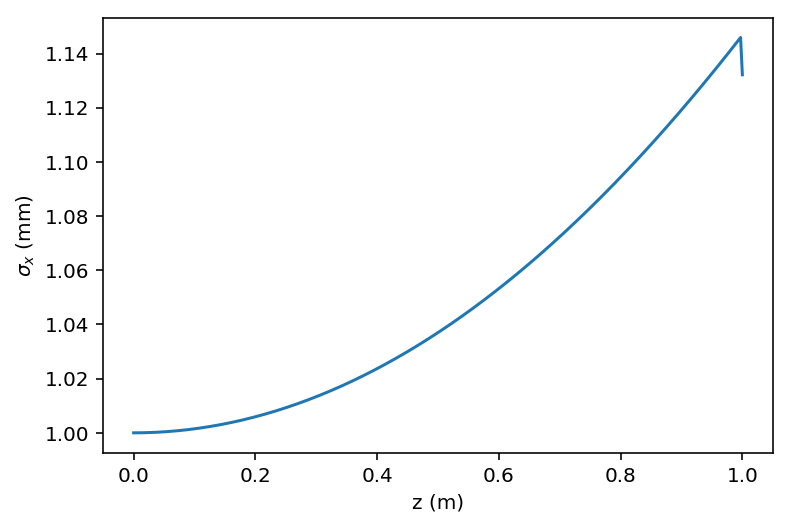

In [107]:
from gpt import GPT

drift = 1

settings = {
    'space_charge': 1,
    'Alpha': 1.0,
    'Fn':  0.5,
    'verror':  0.01,
    'Nstd':  12,
    'Ntout': 500,
    'tmax': 1.5*drift/3e8
}

G = GPT(input_file=GPT_FILE, initial_particles = P, verbose=True)
sets = G.set_variables(settings)
print(sets)
G.run()

z = G.stat('mean_z','tout')
stdx = G.stat('sigma_x','tout')*1000

plt.plot(z, stdx)
plt.xlabel('z (m)')
plt.ylabel('$\sigma_x$ (mm)');

tout z-pos: 0.9940140027615179


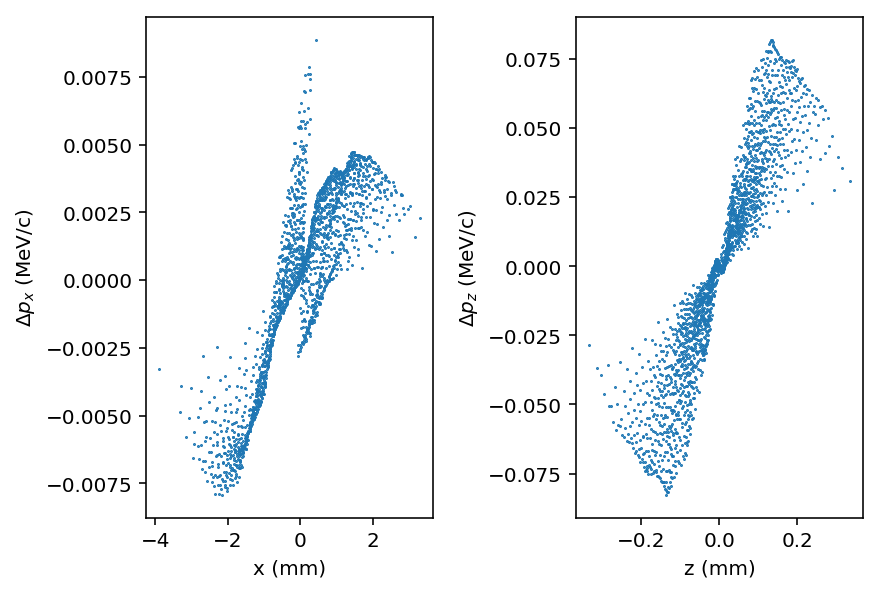

In [108]:
import numpy as np

fig, ax = plt.subplots(1,2, constrained_layout=True)

Pf = G.tout[-3]
print('tout z-pos:',np.mean(Pf['z']))

ax[0].plot(Pf['x']*1000, Pf['delta_px']/1e6, '.', markersize=1)
ax[0].set_xlabel('x (mm)')
ax[0].set_ylabel('$\Delta p_x$ (MeV/c)');

ax[1].plot(Pf['delta_z']*1000, Pf['delta_pz']/1e6, '.', markersize=1)
ax[1].set_xlabel('z (mm)')
ax[1].set_ylabel('$\Delta p_z$ (MeV/c)');

# Clean up:

In [109]:
import os
os.system('rm gpt.drift.in');